In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
from scipy.sparse.linalg import LinearOperator
from scipy.fft import fft, ifft, fft2, ifft2
from scipy.optimize import minimize
from sklearn import datasets
from scipy.stats import multivariate_normal
from scipy.signal import butter, lfilter

#### Play around version, not connected to Github

Consider retrieving $x \in \mathbb{C}^n$ from measurements

$$y = \mathcal{A}(x) + \epsilon,$$

by solving

$$\min_z J(z), \quad J(z)  = \|\mathcal{A}\circ \mathcal{G} (z) - y\|_2^2 + \lambda^2\|z\|_2^2,$$

where $\mathcal{G}$ is a generative model.

The gradient of $J$ is given by

$$\nabla J(z) = \left(\mathcal{G}'(z)\right)^*\left(\mathcal{A}'(x)\right)^*\left(\mathcal{A}\circ \mathcal{G} (z) - y\right),$$

with $x = \mathcal{G}(z)$ and $\mathcal{G}'(z)$ the Jacobian of $\mathcal{G}$ and $\mathcal{A}'(x)$ the Jacobian of $\mathcal{A}$. 

We typically consider 

$$\mathcal{A}(x) = |Ax|^2,$$

for some given matrix $A \in \mathbb{C}^{m\times n}$. In that case we have

$$\mathcal{A}'(x) = 2\text{diag}(Ax)\overline{A}.$$

We take $A$ to be a masked Fourier transform, in which case it is given by

$$A = \left(\begin{matrix} FM_1 \\ FM_2 \\ \vdots \\ FM_m\end{matrix}\right),$$

with $F \in \mathbb{C}^{n\times n}$ the 2D Fourier transform and $M_i \in \mathbb{C}^{n\times n}$ a diagonal matrix containing a mask.

A simple generative model can be obtained as

$$\mathcal{G}(z) = \mu + Sz, $$

with $\mu$ the mean of the training samples, and $S$ a Cholesky factorisation of the sample covariance matrix (i.e., $\Sigma = SS^*$.)

We can also let $\mathcal{G}(z) = z$ and $\mathcal{G}(z) = \mu + Sz_1 + z_2$.

In [12]:
class Op:
    def __init__(self, fun, jac, shape):
        self.eval = fun
        self.jac = jac
        self.shape = shape
        
def objective(z, y, A, G, w=1, lmbda = 0):
    """
    LS objective
        (0.5)*\|A(G(z)) - y\|_2^2 + 0.5*lmbda**2*\|w*z\|_2^2
    """
    if len(y) != A.shape[0]:
        print("y and A don't match")
        return
    if len(z)//2 != G.shape[1]:
        print("z and G don't match")
        return
    if A.shape[1] != G.shape[0]:
        print("A and G don't match!")
        return
    
    k  = len(z)//2
    zc = z[:k] + 1j*z[k:]
    
    xc = G.eval(zc)
    Dx = G.jac(zc)
    
    yp = A.eval(xc)
    Dy = A.jac(xc)
    print(Dy.shape)

    val    = (0.5)*np.linalg.norm(yp - y)**2 + (0.5*lmbda**2)*np.linalg.norm(w*zc)**2
    gradc  = Dx.H@(Dy.H@(yp - y)) + (lmbda**2)*(w*w)*zc
    print(gradc.shape)
    
    grad  = np.concatenate((np.real(gradc), np.imag(gradc)))
    
    return val, grad

def reconstruct(xtrue, A, G, w=1, sigma=0, lmbda=0):
    # sizes
    m,n = A.shape
    n,k = G.shape
    
    # generate data
    yobs  = A.eval(xtrue) + sigma*np.random.randn(m)

    # inference
    result = minimize(objective, x0=np.ones(2*k), args=(yobs, A, G, w, lmbda), method='L-BFGS-B', jac=True)
    
    # result
    zhat = result.x[:k] + 1j*result.x[k:]
    xhat = G.eval(zhat)
    
    # correct global phase
    phi = np.mean(np.angle(xtrue/xhat))
    xhat_corr = np.exp(1j*phi)*xhat
    
    # relative error
    error = np.linalg.norm(xhat_corr - xtrue)/np.linalg.norm(xtrue)
    
    # return
    return error, xhat_corr, yobs, result

def plot_result(xtrue, xhat):
    n  = len(xtrue)
    nx = int(np.sqrt(n))
    
    # plot results
    fig, ax = plt.subplots(2,2)

    ax[0,0].imshow(np.real(xtrue.reshape((nx,nx))),clim=[0,1])
    ax[0,0].set_title(r'$\Re(x_{true})$')
    ax[1,0].imshow(np.imag(xtrue.reshape((nx,nx))),clim=[0,1])
    ax[1,0].set_title(r'$\Im(x_{true})$')
    ax[0,1].imshow(np.real(xhat.reshape((nx,nx))),clim=[0,1])
    ax[0,1].set_title(r'$\Re(x_{est})$')
    ax[1,1].imshow(np.imag(xhat.reshape((nx,nx))),clim=[0,1])
    ax[1,1].set_title(r'$\Im(x_{est})$')

    fig.tight_layout()

In [3]:
def MaskedFourier(M):
    """
    Defined masked 2D fourier transform as linear operator.
    
    input:
        M - 3D array of size n x n x m containing m masks of size n x n
        
    out:
        A - linear operator representing the masked Fourier transforms
        
    
    """
    nx = M.shape[0]
    mx = M.shape[2]
    
    mv  = lambda x : fft2(M*(x.reshape((nx,nx,1))), axes=(0,1)).flatten()
    rmv = lambda y : nx*nx*np.sum(np.conj(M)*ifft2(y.reshape((nx,nx,mx)), axes=(0,1)),axis=2).flatten()
    A   = LinearOperator((mx*nx*nx, nx*nx), matvec=mv, rmatvec=rmv) # rmatvec is conjugate operation, so A^H * v
    
    return A

In [ ]:
# might not work? do something with tensors?
def Ambiguity2D(phi,m): #for now, ignore specific frequency component n and compute all
    '''
    input:
        phi - n x n signal
        m - shift of the signal, has 2 coordinates
    '''
    mx, my = m[0], m[1]
    shift_phi = np.conjugate(np.roll(np.roll(phi, mx, axis=0), my, axis=1))
    correlation = phi*shift_phi
    return fft2(correlation)

In [4]:
# load data set of 3's
(digits, cls) = datasets.load_digits(return_X_y=True)
X = np.ones((183, 64)) + 1j*digits[np.where(cls==3)[0],:]/16 # cls is the label so all digits of 3, normalized to fit [0,1]

n = X.shape[1]
nx = int(np.sqrt(n))
print(n)
print(nx)

64
8


In [ ]:
# create data set with threshold delta (positive real numbers)
delta = 0.1
X = np.random.uniform(delta,1+delta,(180,64))

n = X.shape[1]
nx = int(np.sqrt(n))

6.970265589694112


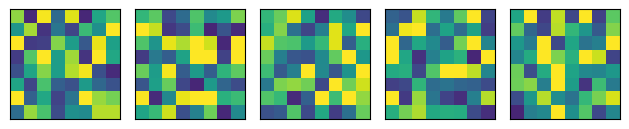

In [ ]:
# 2D representation of random data set
ns = 5
fig, ax = plt.subplots(1,ns)

for i in range(ns):
    x = X[i]
    ax[i].imshow(np.real(x).reshape((nx,nx)),clim=[0,1])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
fig.tight_layout()

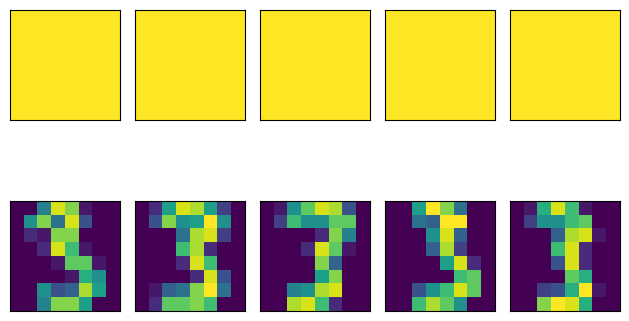

In [7]:
ns = 5
fig, ax = plt.subplots(2,ns)

for i in range(ns):
    x = X[i]
    ax[0,i].imshow(np.real(x).reshape((nx,nx)),clim=[0,1])
    ax[0,i].set_xticks([])
    ax[0,i].set_yticks([])
    ax[1,i].imshow(np.imag(x).reshape((nx,nx)),clim=[0,1])
    ax[1,i].set_xticks([])
    ax[1,i].set_yticks([])
fig.tight_layout()

plt.savefig('example1_data.png',dpi=300)

In [5]:
# get prior
mu    = np.mean(X,axis=0)
Sigma = np.conj((X-mu).T)@(X-mu)/X.shape[0]
s, U = np.linalg.eigh(Sigma + 1e-6*np.eye(n))

k = 30
B = U[:,-k:]@np.diag(np.sqrt(s[-k:]))

C = np.concatenate((np.real(B), np.eye(n)), axis=1)

# define generative models
G = Op(fun = lambda z : mu + B@z, jac = lambda z : LinearOperator((n, k), matvec = lambda z : B@z, rmatvec = lambda z : np.conj(B.T)@z), shape=(n,k))
I = Op(fun = lambda z : z, jac = lambda z: LinearOperator((n, n), matvec = lambda z : z, rmatvec = lambda z : z), shape=(n,n))
H = Op(fun = lambda z : mu + C@z, jac = lambda z : LinearOperator((n, k+n), matvec = lambda z : C@z, rmatvec = lambda z : np.conj(C.T)@z), shape=(n,k+n))

# define weights
w = 1

In [7]:
# bandpass signals functions
# source: https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [ ]:
# get a prior from bandpassed signals
# have to decide on viable lowcut and highcut
# first without the whole operator class? but not sure how it would be compatible with the rest of the code -> it is not linear so would not do this
# maybe should analyse the fourier modes/frequencies first to know what can be removed
lowcut = 500
highcut = 1000
fs = 5000 # i have no clue what the sampling rate should be but this generally produces no error

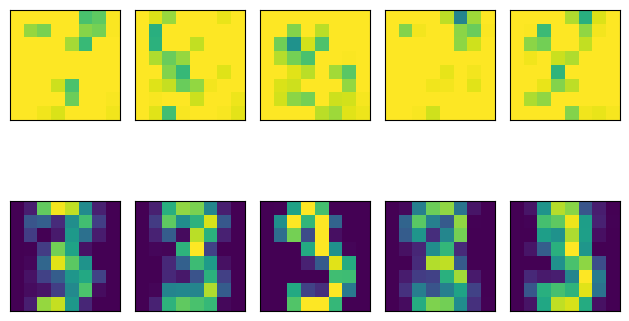

In [ ]:
ns = 5
fig, ax = plt.subplots(2,ns)

for i in range(ns):
    z = np.random.randn(k) + 1j*np.random.randn(k)
    x = G.eval(z)
    ax[0,i].imshow(np.real(x).reshape((nx,nx)),clim=[0,1])
    ax[0,i].set_xticks([])
    ax[0,i].set_yticks([])
    ax[1,i].imshow(np.imag(x).reshape((nx,nx)),clim=[0,1])
    ax[1,i].set_xticks([])
    ax[1,i].set_yticks([])
fig.tight_layout()

plt.savefig('example1_generative.png',dpi=300)

In [9]:
# define forward operator with binary masks
mx = 100
m  = mx * n

M = np.random.randn(nx,nx,mx)
M[M<0]=0
M[M>0]=1

MF   = MaskedFourier(M)
print(MF.shape)
Afun = lambda x : np.abs(MF@x)**2
Ajac = lambda x : LinearOperator((m, n), matvec=lambda z : 2*(MF@x)*np.conj(MF@np.conj(z)), rmatvec=lambda z : 2*(MF.H@((MF@x)*z)))

A    = Op(fun = Afun, jac = Ajac, shape=(m,n))

(6400, 64)


(8, 8)


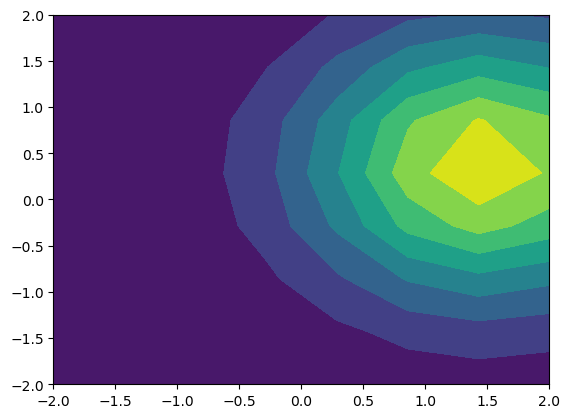

In [ ]:
# test discrete bivariate normal masks
Sigma_masks = np.eye(2)
mu_masks = np.random.uniform(-2.000001,2,2)
x_values = np.linspace(-2, 2, nx)
y_values = np.linspace(-2, 2, nx)
X, Y = np.meshgrid(x_values, y_values)
pos = np.dstack((X,Y))

# grid of multivariate normal
rv = multivariate_normal(mu_masks,Sigma_masks)
z = rv.pdf(pos)

# plot
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.contourf(X, Y, z)

In [39]:
# define forward operator with gaussian masks
mx = 100
m  = mx * n

Sigma_masks = np.eye(2)
mu_masks = np.random.uniform(-2, 2, (mx, 2)) 
x_values = np.linspace(-2, 2, nx)
y_values = np.linspace(-2, 2, nx)
X_val, Y_val = np.meshgrid(x_values, y_values)
pos = np.dstack((X_val,Y_val))

# create matrix of masks
# reshape mu for broadcasting: (1, 1, mx, 2)
mu_broadcasted = mu_masks[np.newaxis, np.newaxis, :, :]
pos_broadcasted = pos[:, :, np.newaxis, :]  # shape: (nx, nx, 1, 2)

# compute each pdf of a mask
rv = multivariate_normal(mean=[0, 0], cov=Sigma_masks)  # placeholder to compute multiple
M = rv.pdf(pos_broadcasted - mu_broadcasted)  # shape: (nx, nx, mx)

# normalize the masks (???)
#M = M / M.sum(axis=(0, 1), keepdims=True) 

MF   = MaskedFourier(M)
Afun = lambda x : np.abs(MF@x)**2
Ajac = lambda x : LinearOperator((m, n), matvec=lambda z : 2*(MF@x)*np.conj(MF@np.conj(z)), rmatvec=lambda z : 2*(MF.H@((MF@x)*z)))

A    = Op(fun = Afun, jac = Ajac, shape=(m,n))

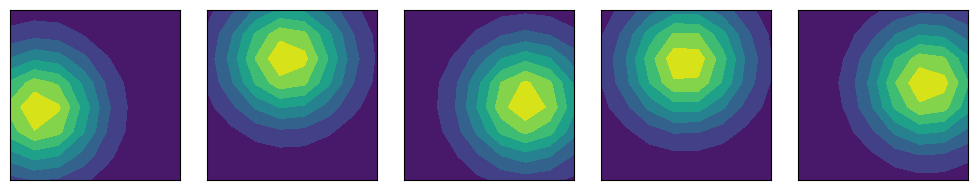

In [158]:
# plot some of the normal masks
ns = 5
fig, ax = plt.subplots(1,ns, figsize=(10, 2))

for i in range(ns):
    ax[i].contourf(X_val, Y_val, M[:,:,i+5])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_aspect('equal')
fig.tight_layout()

#plt.suptitle("Gaussian masks")
plt.savefig('example1_masks_normal.png',dpi=300)

0.00024189095817911573
621705404.0370643
1.608478860737686e-09
81


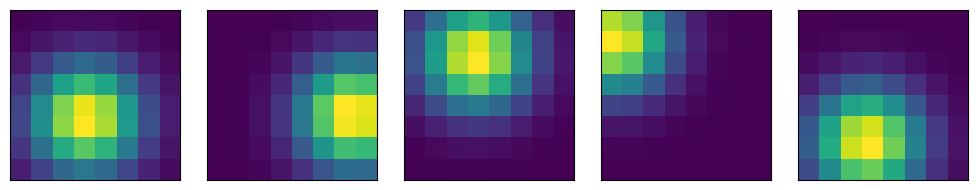

In [ ]:
# test ambiguity function of masks
mask_test = Ambiguity2D(M[:,:,6], (1,0))
c = 1/(abs(mask_test)).min()
print(abs(mask_test).min())

# should test for all shifts (0,0), (1,0), (0,1) and maybe (1,1)
m_shift = np.array([[0,0],[0,1],[1,0]])
c = 0
for i in range(3):
    for j in range(mx): 
        mask_test = Ambiguity2D(M[:,:,j], m_shift[i,:])
        temp_max = 1/abs(mask_test).min()
        if temp_max > c:
            c = temp_max
            remember_mask_index = j
print("The value of c is", c)
print(1/c)
print(remember_mask_index)

# plot the normal masks in a discrete set-up
ns = 5
fig, ax = plt.subplots(1, ns, figsize=(10, 2))

for i in range(ns):
    im = ax[i].imshow(M[:, :, i + 5], origin='upper', cmap='viridis', interpolation='nearest')
    ax[i].set_xticks(range(8))  # Optional: Show gridlines based on the 8x8 grid
    ax[i].set_yticks(range(8))
    ax[i].grid(color='white', linestyle='-', linewidth=0.5)  # Optional: Add gridlines
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_aspect('equal')

fig.tight_layout()

# plt.suptitle("Gaussian masks")
plt.savefig('example1_masks_normal_discrete.png', dpi=300)

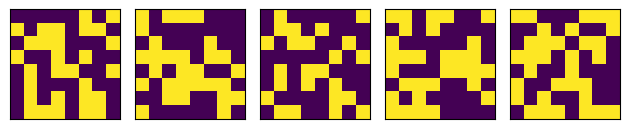

In [7]:
# plot some of the binary masks
ns = 5
fig, ax = plt.subplots(1,ns)

for i in range(ns):
    z = np.random.randn(k) + 1j*np.random.randn(k)
    x = G.eval(z)
    ax[i].imshow(M[:,:,i],clim=[0,1])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
fig.tight_layout()

plt.savefig('example1_masks_binary.png',dpi=300)

(6400, 64)
(30,)
(6400, 64)
(30,)
(6400, 64)
(30,)
(6400, 64)
(30,)
(6400, 64)
(30,)
(6400, 64)
(30,)
(6400, 64)
(30,)
(6400, 64)
(30,)
(6400, 64)
(30,)
(6400, 64)
(30,)
(6400, 64)
(30,)
(6400, 64)
(30,)
(6400, 64)
(30,)
(6400, 64)
(30,)
(6400, 64)
(30,)
(6400, 64)
(30,)
(6400, 64)
(30,)
(6400, 64)
(30,)
(6400, 64)
(30,)
(6400, 64)
(30,)
(6400, 64)
(30,)
(6400, 64)
(30,)
(6400, 64)
(30,)
(6400, 64)
(30,)
(6400, 64)
(30,)
(6400, 64)
(30,)
(6400, 64)
(30,)
(6400, 64)
(30,)
(6400, 64)
(30,)
(6400, 64)
(30,)
(6400, 64)
(30,)
(6400, 64)
(30,)
(6400, 64)
(30,)
(6400, 64)
(30,)
(6400, 64)
(30,)
(6400, 64)
(30,)
(6400, 64)
(30,)
(6400, 64)
(30,)
(6400, 64)
(30,)
(6400, 64)
(30,)
(6400, 64)
(30,)
(6400, 64)
(30,)
(6400, 64)
(30,)
(6400, 64)
(30,)
(6400, 64)
(30,)
(6400, 64)
(30,)
(6400, 64)
(30,)
(6400, 64)
(30,)
(6400, 64)
(30,)
(6400, 64)
(30,)
(6400, 64)
(30,)
(6400, 64)
(30,)
(6400, 64)
(30,)
(6400, 64)
(30,)
(6400, 64)
(30,)
(6400, 64)
(30,)
(6400, 64)
(30,)
(6400, 64)
(30,)
(6400, 64)
(30

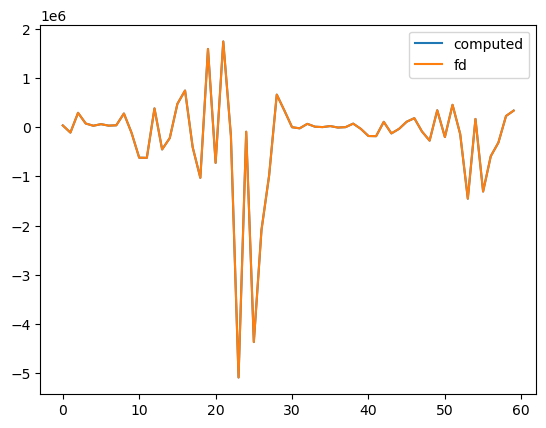

In [13]:
# gradient test
h = 1e-8

k  = G.shape[1]
zt = np.random.randn(2*k)
yt = np.random.randn(A.shape[0])

obj = lambda z : objective(z, yt, A, G)

val, grad = obj(zt)

grad_fd = np.zeros(2*k)
for i in range(2*k):
    e = np.zeros(2*k)
    e[i] = 1
    
    grad_fd[i] = (obj(zt+h*e)[0] - obj(zt-h*e)[0])/(2*h)

print(np.linalg.norm(grad_fd - grad) / np.linalg.norm(grad))

plt.plot(grad, label='computed')
plt.plot(grad_fd, label='fd')
plt.legend()

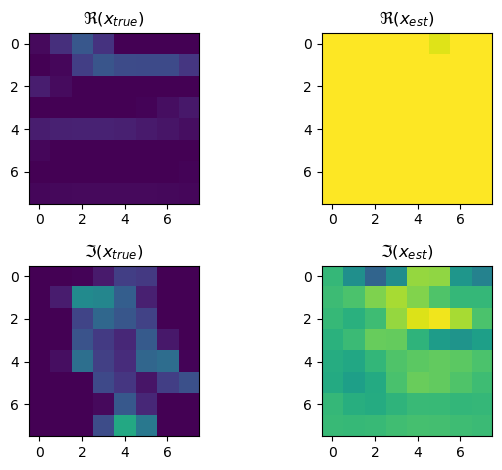

In [84]:
# reconstruct without generative model and plot result
lowcut = 200
highcut = 1400
fs = 5000
# delta = 0.1 (for threshold experiment)

xtrue = X[0]
xtrue = butter_bandpass_filter(xtrue,lowcut,highcut, fs, order = 6)
#xold = xtrue.copy()

# thresholding
# magnitudes = np.abs(xtrue)
# mask = magnitudes <= delta
# xtrue[mask] = (delta / magnitudes[mask]) * xtrue[mask]

error, xhat, yobs, result = reconstruct(xtrue, A, I) # or G? why?

plot_result(xtrue, xhat)

#print("Modified signal:", xtrue-xold)

In [ ]:
# scan over noise levels with and without generative model on in-distribution gt
ns     = 10
sigmas = np.logspace(-6,6,10)

errors_i = np.zeros((len(sigmas),ns))
xhats_i  = np.zeros((len(sigmas),ns, n),dtype='complex')

errors_g = np.zeros((len(sigmas),ns))
xhats_g  = np.zeros((len(sigmas),ns, n),dtype='complex')

errors_c = np.zeros((len(sigmas),ns))
xhats_c  = np.zeros((len(sigmas),ns, n),dtype='complex')

for i in range(len(sigmas)):
    for j in range(ns):
        xtrue = G.eval(np.random.randn(k) + 1j*np.random.randn(k)) #here xtrue comes from the generative model

        errors_i[i,j], xhats_i[i,j,:], _, _ = reconstruct(xtrue, A, I, w=1, sigma=sigmas[i], lmbda=sigmas[i])
        errors_g[i,j], xhats_g[i,j,:], _, _ = reconstruct(xtrue, A, G, w=1, sigma=sigmas[i], lmbda=sigmas[i])
        errors_c[i,j], xhats_c[i,j,:], _, _ = reconstruct(xtrue, A, H, w=1, sigma=sigmas[i], lmbda=1e1*sigmas[i])

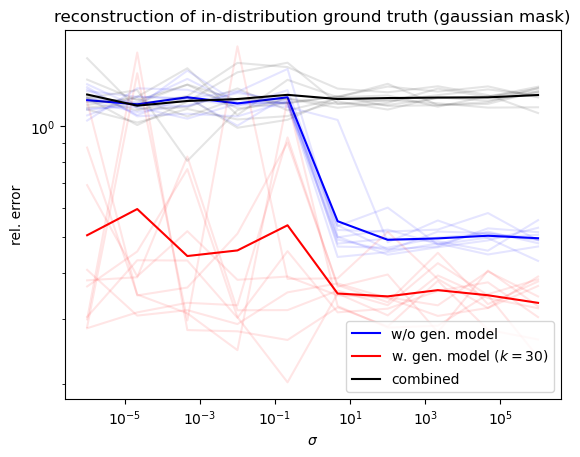

In [78]:
fig, ax = plt.subplots(1)

ax.loglog(sigmas, np.mean(errors_i,axis=1), 'b', label='w/o gen. model')
ax.loglog(sigmas, errors_i, 'b', alpha=1/ns)

ax.loglog(sigmas, np.mean(errors_g,axis=1), 'r', label='w. gen. model ($k=$%d)'%k)
ax.loglog(sigmas, errors_g, 'r', alpha=1/ns)

ax.loglog(sigmas, np.mean(errors_c,axis=1), 'k', label='combined')
ax.loglog(sigmas, errors_c, 'k', alpha=1/ns)

ax.set_xlabel(r'$\sigma$')
ax.set_ylabel('rel. error')
ax.set_title('reconstruction of in-distribution ground truth (gaussian mask)')
ax.legend()

#plt.savefig('example1_recon1_gaussian.png', dpi=300)

In [85]:
# scan over noise levels with and without generative model on out-of-distribution gt
ns     = 10
sigmas = np.logspace(-6,6,10)

errors_i = np.zeros((len(sigmas),ns))
xhats_i  = np.zeros((len(sigmas),ns, n),dtype='complex')

errors_g = np.zeros((len(sigmas),ns))
xhats_g  = np.zeros((len(sigmas),ns, n),dtype='complex')

errors_c = np.zeros((len(sigmas),ns))
xhats_c  = np.zeros((len(sigmas),ns, n),dtype='complex')

for i in range(len(sigmas)):
    for j in range(ns):
        xtrue = X[np.random.randint(0,X.shape[0])]
        xtrue = butter_bandpass_filter(xtrue,1,1500,5000, order = 6)

        errors_i[i,j], xhats_i[i,j,:], _, _ = reconstruct(xtrue, A, I, w=1, sigma=sigmas[i], lmbda=sigmas[i])
        errors_g[i,j], xhats_g[i,j,:], _, _ = reconstruct(xtrue, A, G, w=1, sigma=sigmas[i], lmbda=sigmas[i])
        errors_c[i,j], xhats_c[i,j,:], _, _ = reconstruct(xtrue, A, H, w=1, sigma=sigmas[i], lmbda=1e1*sigmas[i])

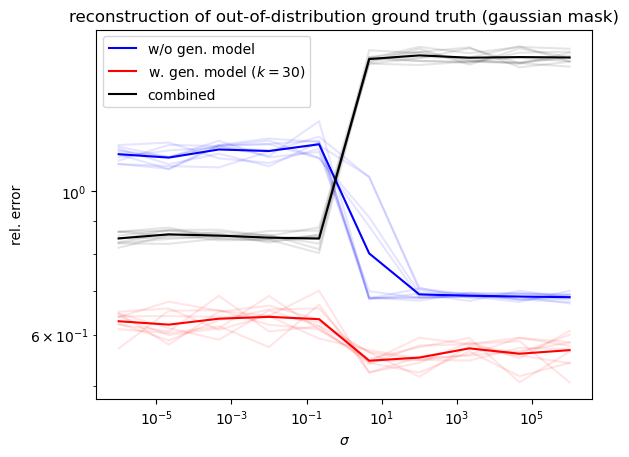

In [86]:
fig, ax = plt.subplots(1)

ax.loglog(sigmas, np.mean(errors_i,axis=1), 'b', label='w/o gen. model')
ax.loglog(sigmas, errors_i, 'b', alpha=1/ns)

ax.loglog(sigmas, np.mean(errors_g,axis=1), 'r', label='w. gen. model ($k=$%d)'%k)
ax.loglog(sigmas, errors_g, 'r', alpha=1/ns)

ax.loglog(sigmas, np.mean(errors_c,axis=1), 'k', label='combined')
ax.loglog(sigmas, errors_c, 'k', alpha=1/ns)

ax.set_xlabel(r'$\sigma$')
ax.set_ylabel('rel. error')
ax.set_title('reconstruction of out-of-distribution ground truth (gaussian mask)')

ax.legend()
plt.savefig('example1_recon2_gaussian.png', dpi=300)